Best validation mae_orig at epoch 185: 2199.5889


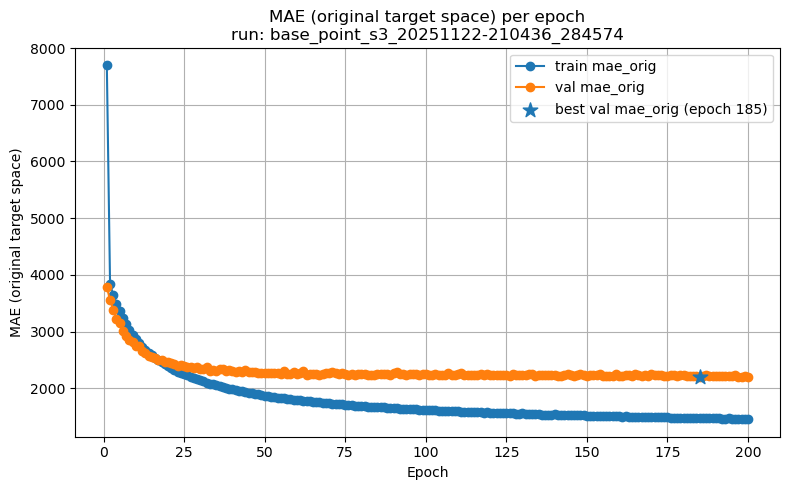

In [ ]:
# === Cell: Plot train vs validation curve for a selected metric ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# User config
# ------------------------------------------------------------------
# 1) Training run directory: folder that contains metrics.csv
RUN_DIR = Path(
    r"Z:\uncertainty_quantification\outputs\trainings\training_base_point_2_20251122-1307\base_point_s3_20251122-210436_284574"
)  # <-- change to the run you want

# 2) Metric selector:
#    Supported:
#      "loss"        -> training/validation loss (head-specific; log-space)
#      "mae"         -> MAE on transformed/log-space target
#      "rmse"        -> RMSE on transformed/log-space target
#      "mse"         -> derived from rmse**2
#      "mae_orig"    -> MAE on original target space (after inverse transform)
#      "rmse_orig"   -> RMSE on original target space
#      "mse_orig"    -> derived from rmse_orig**2
#      "nll"         -> mean NLL (for gauss/laplace heads; may be 0 for point)
METRIC = "mae_orig"

# Pretty y-labels
USE_VERBOSE_LABELS = True

# ------------------------------------------------------------------
# Load and prepare metrics
# ------------------------------------------------------------------
csv_path = RUN_DIR / "metrics.csv"
if not csv_path.is_file():
    raise FileNotFoundError(f"metrics.csv not found at: {csv_path}")

df = pd.read_csv(csv_path)

# Handle derived metrics
derived_map = {
    "mse": "rmse",
    "mse_orig": "rmse_orig",
}
if METRIC in derived_map:
    base = derived_map[METRIC]
    if base not in df.columns:
        raise ValueError(
            f"Cannot derive '{METRIC}' because base column '{base}' "
            f"is missing from metrics.csv. Available columns: {list(df.columns)}"
        )
    # ensure numeric then derive
    df[base] = pd.to_numeric(df[base], errors="coerce")
    df[METRIC] = df[base] ** 2
else:
    if METRIC not in df.columns:
        raise ValueError(
            f"Metric '{METRIC}' not found in metrics.csv. "
            f"Available columns: {list(df.columns)}"
        )
    df[METRIC] = pd.to_numeric(df[METRIC], errors="coerce")

# Keep only train/val rows and drop NaNs for the selected metric
df_plot = df[df["split"].isin(["train", "val"])].copy()
df_plot = df_plot.dropna(subset=[METRIC])

train = df_plot[df_plot["split"] == "train"]
val = df_plot[df_plot["split"] == "val"]

# ------------------------------------------------------------------
# Find best validation epoch for the selected metric
# ------------------------------------------------------------------
best_epoch = None
best_val_metric = None

if not val.empty:
    # For metrics where "lower is better" (all of the ones we support here)
    idx_best = val[METRIC].idxmin()
    best_row = val.loc[idx_best]
    best_epoch = int(best_row["epoch"])
    best_val_metric = float(best_row[METRIC])
    print(
        f"Best validation {METRIC} at epoch {best_epoch}: "
        f"{best_val_metric:.4f}"
    )

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))

if not train.empty:
    plt.plot(
        train["epoch"], train[METRIC],
        label=f"train {METRIC}",
        marker="o",
    )
if not val.empty:
    plt.plot(
        val["epoch"], val[METRIC],
        label=f"val {METRIC}",
        marker="o",
    )

# Mark best validation epoch
if best_epoch is not None:
    plt.scatter(
        [best_epoch], [best_val_metric],
        marker="*", s=120, zorder=5,
        label=f"best val {METRIC} (epoch {best_epoch})",
    )

metric_label_map = {
    "loss": "Training loss (head-specific)",
    "mae": "MAE (model output space)",
    "rmse": "RMSE (model output space)",
    "mse": "MSE (model output space)",
    "mae_orig": "MAE (original target space)",
    "rmse_orig": "RMSE (original target space)",
    "mse_orig": "MSE (original target space)",
    "nll": "Negative log-likelihood",
}
ylabel = metric_label_map.get(METRIC, METRIC) if USE_VERBOSE_LABELS else METRIC

plt.xlabel("Epoch")
plt.ylabel(ylabel)
plt.title(f"{ylabel} per epoch\nrun: {RUN_DIR.name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
df_cleaned = pd.read_csv(r"C:\Users\canel\Desktop\craigslist_cleaned.csv")
backup = df_cleaned.copy()

In [9]:
results_location = r"Z:\uncertainty_quantification\outputs\evals"
results_list = ['base_point_s1_20251122-210424_284572'
            
                ] 
results_dict = {}


base_path = Path(results_location)
print(base_path)

for i, result in enumerate(results_list):
    i = i + 1
    specific_location = base_path / result / 'test_preds.csv'
    print(specific_location)
    results_dict[f'seed_{i}'] = pd.read_csv(specific_location)
    print(f"Shape for seed {i}: {results_dict[f'seed_{i}'].shape}")  

Z:\uncertainty_quantification\outputs\evals
Z:\uncertainty_quantification\outputs\evals\base_point_s1_20251122-210424_284572\test_preds.csv
Shape for seed 1: (66293, 3)


In [10]:
from functools import reduce

# Start from your original df
df_merged = df_cleaned.copy()

# 1) Prepare each seed df: keep only id + y_pred, rename y_pred per seed
seed_dfs = []
for i in range(1, len(results_list) + 1):
    seed_df = results_dict[f"seed_{i}"][["id", "y_pred"]].copy()
    seed_df = seed_df.rename(columns={"y_pred": f"y_pred_s{i}"})
    seed_dfs.append(seed_df)

# 2) Inner-join all seed dfs with the main df on 'id'
#    Only rows present in ALL datasets will be kept because we use how="inner"
df_merged = reduce(
    lambda left, right: pd.merge(left, right, on="id", how="inner"),
    [df_merged] + seed_dfs
)

# Optional: quick sanity check
print(df_cleaned.shape, "->", df_merged.shape)
df_merged.head()


(331468, 22) -> (66293, 23)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,id,y_pred_s1
0,richmond,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,...,not_available,va,33.820600,-84.354900,2021-04-04 07:08:00+00:00,2021-04-04 07:08:37,Y2021Q2,2021,2,24723.013672
1,richmond,11750,2013,honda,civic lx,good,4 cylinders,gas,55000,clean,...,silver,va,37.522967,-77.444730,2021-04-04 07:20:00+00:00,2021-04-04 07:20:50,Y2021Q2,2021,4,11927.368164
2,louisville,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,...,not_available,ky,33.820600,-84.354900,2021-04-04 07:35:00+00:00,2021-04-04 07:35:54,Y2021Q2,2021,6,18703.576172
3,boulder,3350,2009,nissan,altima,fair,4 cylinders,gas,158000,clean,...,blue,co,40.034084,-105.255181,2021-04-04 08:59:00+00:00,2021-04-04 08:59:39,Y2021Q2,2021,17,2934.731934
4,lake of the ozarks,13700,2004,ford,f350 super duty,excellent,6 cylinders,diesel,179000,clean,...,white,mo,36.728400,-91.871700,2021-04-04 09:02:00+00:00,2021-04-04 09:02:21,Y2021Q2,2021,18,14370.689453


In [12]:
df_merged['abs_error'] = (df_merged['price'] - df_merged['y_pred_s1']).abs()
mae = df_merged['abs_error'].mean()
print('MAE:', mae)
df_merged.head()

MAE: 2242.230384332247


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,id,y_pred_s1,abs_error
0,richmond,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,...,va,33.820600,-84.354900,2021-04-04 07:08:00+00:00,2021-04-04 07:08:37,Y2021Q2,2021,2,24723.013672,5786.013672
1,richmond,11750,2013,honda,civic lx,good,4 cylinders,gas,55000,clean,...,va,37.522967,-77.444730,2021-04-04 07:20:00+00:00,2021-04-04 07:20:50,Y2021Q2,2021,4,11927.368164,177.368164
2,louisville,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,...,ky,33.820600,-84.354900,2021-04-04 07:35:00+00:00,2021-04-04 07:35:54,Y2021Q2,2021,6,18703.576172,233.423828
3,boulder,3350,2009,nissan,altima,fair,4 cylinders,gas,158000,clean,...,co,40.034084,-105.255181,2021-04-04 08:59:00+00:00,2021-04-04 08:59:39,Y2021Q2,2021,17,2934.731934,415.268066
4,lake of the ozarks,13700,2004,ford,f350 super duty,excellent,6 cylinders,diesel,179000,clean,...,mo,36.728400,-91.871700,2021-04-04 09:02:00+00:00,2021-04-04 09:02:21,Y2021Q2,2021,18,14370.689453,670.689453


Manufacturers kept (count >= 500): 27


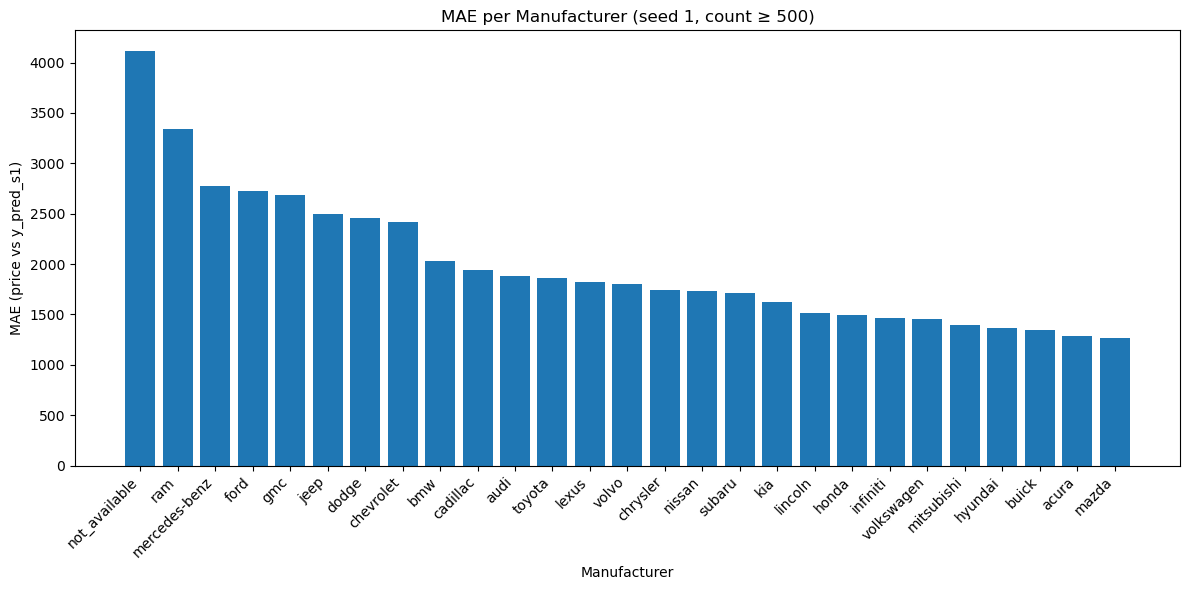

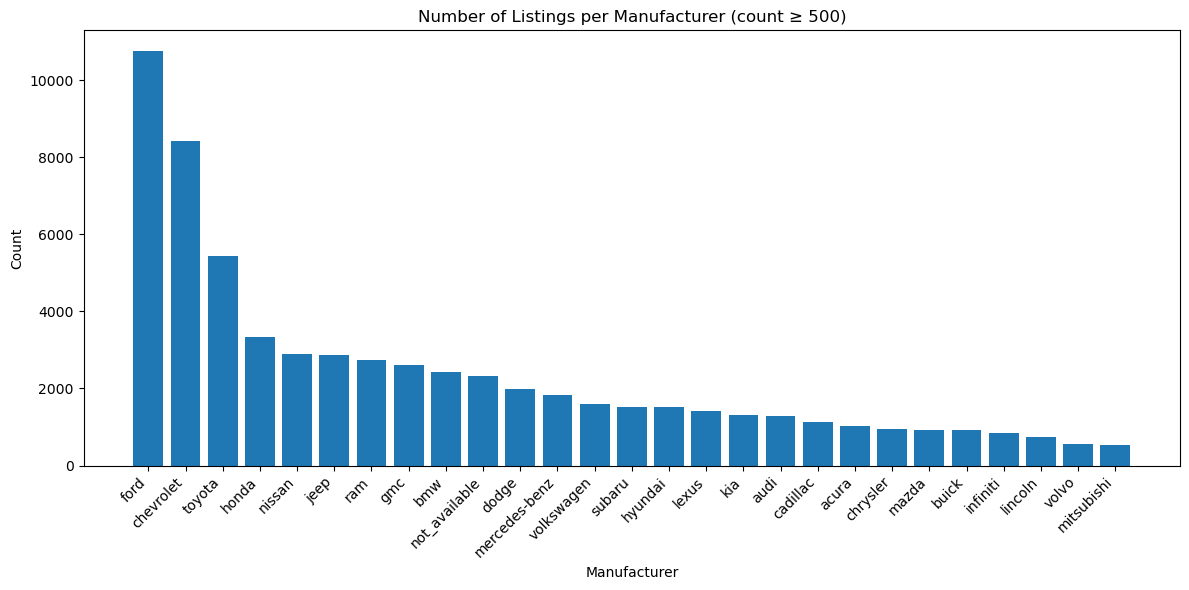

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------
# Config: minimum count per manufacturer
# ---------------------------------------
MIN_COUNT = 500  # <-- change as needed

# ---------------------------------------
# 0) Build summary table (MAE + count)
# ---------------------------------------
abs_err = (df_merged["price"] - df_merged["y_pred_s1"]).abs()

summary = (
    pd.DataFrame({
        "manufacturer": df_merged["manufacturer"],
        "abs_err": abs_err
    })
    .groupby("manufacturer")
    .agg(
        mae=("abs_err", "mean"),
        count=("abs_err", "size")
    )
    .reset_index()
)

# Filter by minimum count
summary_filt = summary[summary["count"] >= MIN_COUNT].copy()

print(f"Manufacturers kept (count >= {MIN_COUNT}): {len(summary_filt)}")

# Optionally sort by MAE or count
summary_by_mae = summary_filt.sort_values("mae", ascending=False)
summary_by_count = summary_filt.sort_values("count", ascending=False)

# ---------------------------------------
# 1) MAE per manufacturer (filtered)
# ---------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(summary_by_mae["manufacturer"], summary_by_mae["mae"])
plt.ylabel("MAE (price vs y_pred_s1)")
plt.xlabel("Manufacturer")
plt.title(f"MAE per Manufacturer (seed 1, count ≥ {MIN_COUNT})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------------------------------------
# 2) Counts per manufacturer (filtered)
# ---------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(summary_by_count["manufacturer"], summary_by_count["count"])
plt.ylabel("Count")
plt.xlabel("Manufacturer")
plt.title(f"Number of Listings per Manufacturer (count ≥ {MIN_COUNT})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Manufacturers kept (count >= 500): 27


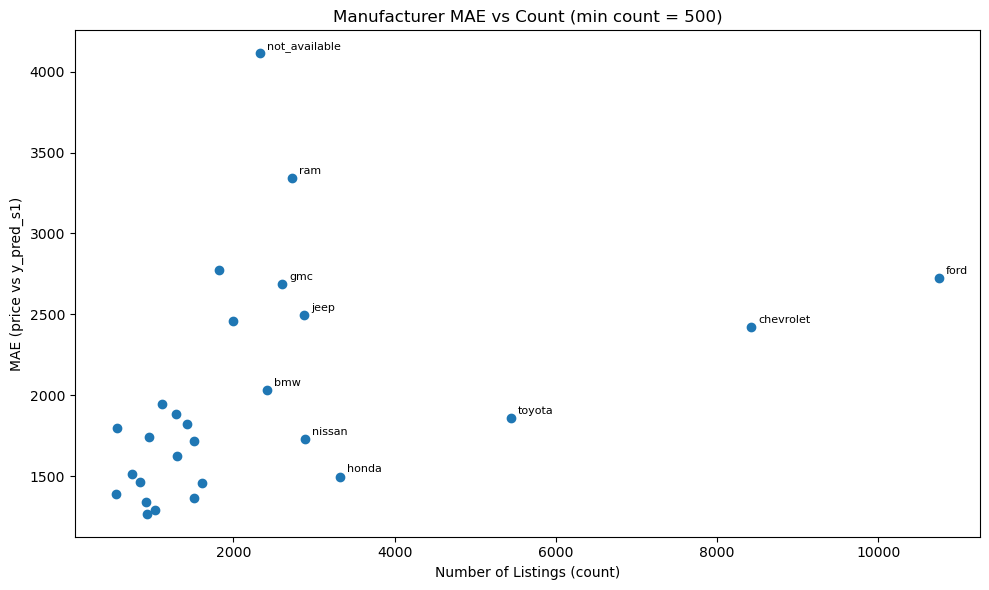

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------
# Config: minimum count per manufacturer
# ---------------------------------------
MIN_COUNT = 500   # <-- change this as you like

# ---------------------------------------
# 1) Build summary df: MAE and count
# ---------------------------------------
# Absolute error per row
abs_err = (df_merged["price"] - df_merged["y_pred_s1"]).abs()

# Group by manufacturer
summary = (
    pd.DataFrame({
        "manufacturer": df_merged["manufacturer"],
        "abs_err": abs_err
    })
    .groupby("manufacturer")
    .agg(
        mae=("abs_err", "mean"),
        count=("abs_err", "size")
    )
    .reset_index()
)

# Filter by minimum count
summary_filtered = summary[summary["count"] >= MIN_COUNT].copy()

print(f"Manufacturers kept (count >= {MIN_COUNT}): {len(summary_filtered)}")

# ---------------------------------------
# 2) Scatter plot: MAE vs Count
# ---------------------------------------
plt.figure(figsize=(10, 6))

plt.scatter(summary_filtered["count"], summary_filtered["mae"])

plt.xlabel("Number of Listings (count)")
plt.ylabel("MAE (price vs y_pred_s1)")
plt.title(f"Manufacturer MAE vs Count (min count = {MIN_COUNT})")

# Optional: label a few points (e.g., top 5 by count)
for _, row in summary_filtered.sort_values("count", ascending=False).head(10).iterrows():
    plt.annotate(row["manufacturer"],
                 (row["count"], row["mae"]),
                 xytext=(5, 3),
                 textcoords="offset points",
                 fontsize=8)

plt.tight_layout()
plt.show()
